In [1]:
from IPython.display import Image
from oct2py import octave as oct
from os.path import join
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_matlab_data(directory, filename):
    """
    Imports the matlab scripts generated during execution of
        C codes, and returns an array with the data neccesary
        for analysis of performance
    """
    oct.eval(f"cd {directory};")
    oct.eval(f"{filename};")
    oct.eval(f"save -v7 {filename}.mat;")
    data = sio.loadmat(f"{join(directory, filename)}.mat")

    return data['data']

# 1.4 Layering Matrix-Matrix Multiplication: Alternatives

## 1.4.1 Rank-1 update (rank-1)
The **rank-1 update** is an operation that will prove important as the
discussion about increasing **matrix - matrix** multiplication advances. The
**rank-1 update** operation is as follows

$$
A := x y^{T} + A
$$

It is called **rank-1 update** because the result of multiplying a column
vector on the left times a row vector on the right is a matrix, whith has *at
most* **rank-1**. When all elements of the matrix and vectors involved are
exposed, the **rank-1** update is computed as

$$
A := x y^{T} + A \\
\begin{bmatrix}
\alpha_{0, 0} & \alpha_{0, 1} & \dots & \alpha_{0, n-1} \\
\alpha_{1, 0} & \alpha_{1, 1} & \dots & \alpha_{1, n-1} \\
\vdots & \vdots & \dots & \vdots \\
\alpha_{m-1, 0} & \alpha_{m-1, 1} & \dots & \alpha_{m-1, n-1} \\
\end{bmatrix}
\; := \;
\begin{bmatrix}
\chi_0 \\ \chi_1 \\ \vdots \\ \chi_{m-1}
\end{bmatrix}
\begin{bmatrix}
\psi_0 & \psi_1 & \dots & \psi_{n-1}
\end{bmatrix}
\; + \;
\begin{bmatrix}
\alpha_{0, 0} & \alpha_{0, 1} & \dots & \alpha_{0, n-1} \\
\alpha_{1, 0} & \alpha_{1, 1} & \dots & \alpha_{1, n-1} \\
\vdots & \vdots & \dots & \vdots \\
\alpha_{m-1, 0} & \alpha_{m-1, 1} & \dots & \alpha_{m-1, n-1}
\end{bmatrix}
\\
:= \begin{bmatrix}
\chi_0 \psi_0 + \alpha_{0, 0} & \chi_0 \psi_1 + \alpha_{0, 1} & \dots &
    \chi_0 \psi_{n-1} + \alpha_{0, n-1}\\
\chi_1 \psi_0 + \alpha_{1, 0} & \chi_1 \psi_1 + \alpha_{1, 1} & \dots &
    \chi_1 \psi_{n-1} + \alpha_{1, n-1}\\
\vdots & \vdots & \dots & \vdots \\
\chi_{m-1} \psi_0 + \alpha_{m-1, 0} & \chi_{m-1} \psi_1 + \alpha_{m-1, 1} &
    \dots & \chi_{m-1} \psi_{n-1} + \alpha_{m-1, n-1}
\end{bmatrix}
$$

So each entry $\alpha_{i, j}$ is updated by
$$
\alpha_{i, j} \;\;+=\;\; \chi_i \psi_j
$$

Up to this point, the whole exposure of the entries of the matrix `A` and
vectors `x` and `y_T` has been shown, just in order to help us understand what
**rank-1** is actually computing. With this in mind, we can now begin to slice
each component of the equation the way we think would be more convenient to our
discussion on performance.

We start by noting that we can slice matrix `A` by its columns, $a_j$, which
will in deed impose the need to expose the elements of vector `y` (since `y`
can be seen as a matrix of size `1 x n`), and keep vector `x` as it is (no
exposure), since it is already a column, then we have

$$
\begin{bmatrix}
a_0 & | & a_1 & | & \dots & | & a_{n-1}
\end{bmatrix}
\;+=\;
x \begin{bmatrix}
\psi_0 & | & \psi_1 & | & \dots & | & \psi_{n-1}
\end{bmatrix}
\;+\;
\begin{bmatrix}
a_0 & | & a_1 & | & \dots & | & a_{n-1}
\end{bmatrix}
$$

which leads to

$$
\begin{bmatrix}
a_0 & | & a_1 & | & \dots & | & a_{n-1}
\end{bmatrix}\\
\;=\;
\begin{bmatrix}
\psi_0 x + a_0 & | & \psi_1 x + a_1 & | & \psi_{n-1} x + a_{n-1}
\end{bmatrix}
$$

From this, we can see that every column of matrix `A` is updated via an
**axpy** operation where the scalar is the corresponding entry of `y` $\psi_j$,
the first vector is the vector `x`, and the second vector is the corresponding
column of `A` $a_j$.

A pseudocode to perform such **rank-1** update in terms of **axpy** operations
*by columns* is shown next
```python
"""
BOTH SNIPPETS PERFORM THE SAME RANK-1 UPDATE OPERATION IN TERMS OF
    AXPY operations.
    alpha[i, j] -> element [i, j] of matrix `A`
    chi[i] -> element [i] of vector `x`
    psi[i] -> element [j] of vector `y`
    x -> vector x
    incx -> offset between contiguous elements of vector `x`
    a[j] -> column [j] of matrix `A`
    inca -> offset between contiguous elements of matrix `A`
"""
for j in range(n):
    for i in range(m):
        alpha[i, j] += chi[i] * psi[j]

for j in range(n):
    axpy(m, psi[j], x, incx, a[j], inca)
```

It can also be the case in which we would want to slice matrix `A` by rows,
which will demand us to also expose the individual entries of vector `x`, since
it can be seen as a matrix of dimensions `m x 1`, while keeping vector `y`
without exposure. This leads to

$$
\begin{bmatrix}
a_0^{\sim T} \\ a_1^{\sim T} \\ \vdots \\ a_{m-1}^{\sim T}
\end{bmatrix}
\; = \;
\begin{bmatrix}
\chi_0 \\ \chi_1 \\ \vdots \\ \chi_{m-1}
\end{bmatrix}
y^T \;+\;
\begin{bmatrix}
a_0^{\sim T} \\ a_1^{\sim T} \\ \vdots \\ a_{m-1}^{\sim T}
\end{bmatrix} \\
= \;
\begin{bmatrix}
\chi_0 y^T + a_0^{\sim T} \\
\chi_1 y^T + a_1^{\sim T} \\
\vdots \\
\chi_{m - 1} y^T + a_{m - 1}^{\sim T} \\
\end{bmatrix}
$$

If one observes carefully, one can see that when this *row* exposure is
performed we also end up with an **axpy** approach, but instead this time is
performed by rows, where the corresponding entry of vector `x`, $\chi_i$, is
the scalar, the *row* vector `y_T` is the scaled vector, and the corresponding
*row* of matrix `A`, $a_i^{\sim T}$ is the updated *row* vector.

Below we show a pseudocode for a **rank-1** update operation when we expose the
entries of `A` by rows
```python
"""
BOTH SNIPPETS PERFORM THE SAME RANK-1 UPDATE OPERATION IN TERMS OF
    AXPY operations by ROWS.
    alpha[i, j] -> element [i, j] of matrix `A`
    chi[i] -> element [i] of vector `x`
    psi[i] -> element [j] of vector `y`
    x -> vector x
    incx -> offset between contiguous elements of vector `x`
    a[j] -> column [j] of matrix `A`
    inca -> offset between contiguous elements of matrix `A`
"""
for i in range(m):
    for j in range(n):
        alpha[i, j] += chi[i] * psi[j]

for i in range(m):
    axpy(n, chi[j], y, incy, a[i], inca)
```

###  Homework 1.4.1.2.
In [Assignments/Week1/C/Ger_J_Axpy.c](../Ger_J_Axpy.c) complete the implementation of rank-1 in terms of axpy operations.

```c
#define alpha(i, j) A[(j) * ldA + i]   // map alpha( i,j ) to array A 
#define chi(i)  x[(i) * incx]         // map chi( i )  to array x
#define psi(i)  y[(i) * incy]         // map psi( i )  to array y

/* void Axpy( int, double, double *, int, double *, int ); */
void Axpy(int n, double alpha, double *x, int incx, double *y, int incy);

void MyGer(int m, int n, double *x, int incx,
		double *y, int incy, double *A, int ldA)
{
  for (int j = 0; j < n; j++)
    Axpy(m, *(y + j * incy), x, incx, A + j * ldA, 1);
}
```

###  Homework 1.4.1.4.
In [Assignments/Week1/C/Ger_I_Axpy.c](../Ger_I_Axpy.c) complete the implementation of rank-1 in terms of axpy operations (by rows).

```c
#define alpha(i, j) A[(j) * ldA + i]   // map alpha( i,j ) to array A 
#define chi(i)  x[(i) * incx]         // map chi( i )  to array x
#define psi(i)  y[(i) * incy]         // map psi( i )  to array y

/* void Axpy(int, double, double *, int, double *, int); */
void Axpy(int n, double alpha, double *x, int incx, double *y, int incy);

void MyGer(int m, int n, double *x, int incx,
		 double *y, int incy, double *A, int ldA)
{
	for (int i = 0; i < m; i++)
		Axpy(n, *(x + i * incx),  y, incy, A + i, ldA);
}

```

Test both homeworks by
```bash
cd Assignments/Week1/C/
make Ger_J_Axpy
make Ger_I_Axpy
```

**Note** Since we have two approaches for **matrix - matrix** multiplication
via **rank-1** updates, one by columns and one by rows, we need to pay special
attention to which one of them would be the best fit for our application, in
this case, since we are working in **column major** order the best choiche is
the one that performs the **rank-1** update by columns, if we were dealing
instead with **row major** order, we may want to use the one that does it by
rows.

## 1.4.2 Matrix-matrix multiplication via rank-1 updates
With te previous knowledge in mind, we see that an operation for a **matrix -
matrix** multiplication in terms of **rank-1** operations which in turn are
expressed via **axpy** operations is feasible.

It is important to note here, that since the **rank-1** update operation is
expressed in one of two forms, by performing internally **axpy** operations
either by *columns* or by *rows*, the algorithm for a **matrix - matrix**
multiplication is to be expressed in similar manner, in one of two approaches.
In other words, the **matrix - matrix** multiplication algorithm can also be
taught as a sequence of **rank-1** update operations.

The first step is to expose matrix `A` by its columns $a_p$ while
exposing matrix `B` by its rows $b_p^{\sim T}$.
$$
C := AB + C \\
C \;=\; \begin{bmatrix}
a_0 & | & a_1 & | & \dots & | & a_{k-1}
\end{bmatrix}
\begin{bmatrix}
b_0^{\sim T} \\
--- \\
b_1^{\sim T} \\
--- \\
\vdots \\
--- \\
b_{k-1}^{\sim T} \\
--- \\
\end{bmatrix}
\; + \;
C
$$
if we analyze the above equation, we see that looks similar to a dot product
between two vectors, and in fact this is what one must do, perform a some sort
of dot product but this time the entries are vectors themselves, this leads to
$$
C \;=\;
a_0 b_0^{\sim T} + a_1 b_1^{\sim T} + \dots + a_{k-1} b_{k-1}^{\sim T} \;+\; C
$$

From this we now present a pseudocode that performs **matrix - matrix**
multiplication in terms of **rank-1** updates in ther of axp operations by
columns
```python
"""
THE 3 SNIPPETS PERFORM THE SAME MATRIX-MATRIX by a RANK-1 UPDATE OPERATION IN
    TERMS OF AXPY operations by COLUMNS.
    gamma[i, j] -> element [i, j] of matrix `C`
    alpha[i, p] -> element [i, p] of matrix `A`
    beta[p, j] -> element [p, j] of matrix `B`
    a[p] -> column [p] of matrix `A`
    b_T[p] -> row [p] of matrix `B`
    c[j] -> column [j] of matrix `C`
    """
for p in range(k):
    for j in range(n):
        for i in range(m):
            gamma[i, j] += alpha[i, p] * beta[p, j]

for p in range(k):
    for j in range(n):
        axpy(m, beta[p, j], a[p], inca, c[j], incc)

for p in range(k):
    ger(m, n, a[p], inca, b_T[p], incb, C, ldC)
```

The approach in which we deal with the exposure of rows is shown below
```python
"""
THE 3 SNIPPETS PERFORM THE SAME MATRIX-MATRIX by a RANK-1 UPDATE OPERATION IN
    TERMS OF AXPY operations by ROWS.
    gamma[i, j] -> element [i, j] of matrix `C`
    alpha[i, p] -> element [i, p] of matrix `A`
    beta[p, j] -> element [p, j] of matrix `B`
    a[p] -> column [p] of matrix `A`
    b_T[p] -> row [p] of matrix `B`
    """
for p in range(k):
    for i in range(m):
        for j in range(n):
            gamma[i, j] += alpha[i, p] * beta[p, j]

for p in range(k):
    for j in range(n):
        axpy(n, alpha[i, p], b_T[p], incb, c_T[i], incc)

for p in range(k):
    ger(m, n, a[p], inca, b_T[p], incb, C, ldC)
```

### Homework 1.4.2.2.
Complete the code in [Assignments/Week1/C/Gemm_P_Ger.c](../Gemm_P_Ger.c).

```c
#define alpha(i, j) A[(j) * ldA + i]   // map alpha( i,j ) to array A 
#define beta(i, j)  B[(j) * ldB + i]   // map beta( i,j )  to array B
#define gamma(i, j) C[(j) * ldC + i]   // map gamma( i,j ) to array C

void MyGer( int, int, double *, int, double *, int, double *, int );

void MyGemm(int m, int n, int k, double *A, int ldA,
		double *B, int ldB, double *C, int ldC)
{
	for (int p=0; p < k; p++)
		MyGer(m, n, A + p * ldA, 1, B + p, ldB, C, ldC);
}
```

Test two versions
```sh
cd Assignments/Week1/C/
make P_Ger_J_Axpy 
make P_Ger_I_Axpy
```

error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5


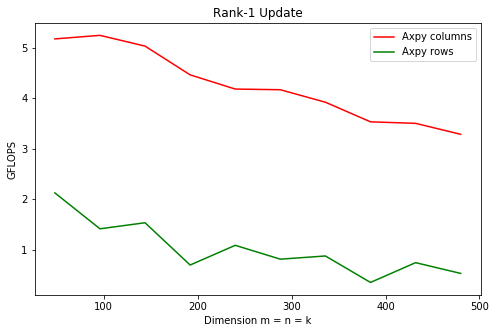

In [4]:
directory = join("..", "data")
filenames = ["output_P_Ger_J_Axpy", "output_P_Ger_I_Axpy"]
labels = ["Axpy columns", "Axpy rows"]
colors = ["r", "g"]

fig_size = [8, 5]
fix, ax = plt.subplots(1, figsize=fig_size)
for file, label, color in zip(filenames, labels, colors):
    data = get_matlab_data(directory, file)
    if np.any(data[:, 5] > 1e-10):
        raise Exception("Hmmm, better check if there is an accuracy problem")
    ax.plot(data[:, 0], data[:, 4], color=color, label=label)
ax.set_title("Rank-1 Update")
ax.set_xlabel("Dimension m = n = k")
ax.set_ylabel("GFLOPS")
ax.legend(loc="upper right")
plt.show()

## 1.4.4 Matrix-matrix multiplication via row-times-matrix multiplications
We finally, present the last method to perform **matrix - matrix**
multiplication, this time in terms of **row - matrix** multiplication
operations, this means that this time the process of slicing is done by rows,
then

$$
C := AB + C
\\
\begin{bmatrix}
c_0^{\sim T} \\
c_1^{\sim T} \\
\vdots \\
c_{m - 1}^{\sim T} \\
\end{bmatrix}
\; = \;
\begin{bmatrix}
a_0^{\sim T} \\
a_1^{\sim T} \\
\vdots \\
a_{m - 1}^{\sim T} \\
\end{bmatrix}
B
\; + \;
\begin{bmatrix}
c_0^{\sim T} \\
c_1^{\sim T} \\
\vdots \\
c_{m - 1}^{\sim T} \\
\end{bmatrix}
$$

a graphic representation of what the above equations means is

![row_matrix_multiplication](./img/row_matrix.png)

Since **row - matrix** multiplication involves in every step to multiplie a row
vector times the corresponding matrix, is basically the same operation than
**matrix - vector** multiplication under the hood (we just advance and update
entries by rows instead of by columns), we have the same two options that we
did when explaining **matrix - vector** multiplication, this is, we can perform
it by performing **axpy** operations as well as **dot product** operations.

A pseudocode for **matrix - matrix** in terms of **row - matrix** operations
which in turn is in terms of **axpy** operations is shown next

```python
"""
THE 3 SNIPPETS PERFORM THE SAME MATRIX-MATRIX by ROW MATRIX OPERATION IN
    TERMS OF AXPY operations.
    gamma[i, j] -> element [i, j] of matrix `C`
    alpha[i, p] -> element [i, p] of matrix `A`
    beta[p, j] -> element [p, j] of matrix `B`
    a[p] -> column [p] of matrix `A`
    b_T[p] -> row [p] of matrix `B`
"""
for i in range(m):
    for p in range(k):
        for j in range(n):
            gamma[i, j] += alpha[i, p] * beta[p, j]

for i in range(m):
    for p in range(k):
        axpy(n, alpha[i, p], b_T[p], ldB, c_T[i], incc)

for i in range(m):
    row_matrix_axpy(n, k, B, a_T[i], c_T[i])
```

As stated before, the **row - matrix** operation can also be computed by
performing a sequence of dot products, the corresponding pseudocode is shown
below
```python
"""
THE 3 SNIPPETS PERFORM THE SAME MATRIX-MATRIX by ROW MATRIX OPERATION IN
    TERMS OF DOT PRODUCT operations.
    gamma[i, j] -> element [i, j] of matrix `C`
    alpha[i, p] -> element [i, p] of matrix `A`
    beta[p, j] -> element [p, j] of matrix `B`
    a[p] -> column [p] of matrix `A`
    b_T[p] -> row [p] of matrix `B`
"""
for i in range(m):
    for j in range(n):
        for p in range(k):
           gamma[i, j] += alpha[i, p] * beta[p, j]

for i in range(m):
    for j in range(n):
        dot_product(k, a_T[i], b[j], gamma[i, j])

for i in range(m):
    row_matrix_dot(n, k, B, a_T[i], c_T[i])
```


## Wrapping up
So far, we've discussed that **matrix - matrix** multiplication in the form of
$$
C := AB + C
$$
where
* C = resulting matrix of size `[m x n]`
* A = *left matrix* of size `[m x k]`
* B = *right matrix* of size `[k x n]`

involves traversing all entries of the three matrices, from their dimensions we
see that we have 3 variables `m, n, k` along which we need to traverse, in code
this means that we need three `for` loops (one for each dimension). From
combinatorics, we know that this gives `6` possible combinations for the order
in which the loops are going to be executed.

Then we analyzed the performance of each one of the six orderings, there we
conclude that the two with the best performances were the ones that had as its
most inner loop the variable `i` (loop along `m`). This is because we are
working with **column major order**, then traversing contiguosly stored
elements along `i` lets us advance by columns of both `C` and `A`. Then we
conclude that the difference in performance between those approaches was the
the better one had as the mid loop a for loop across the `k` dimension
(variable `p`) whereas the worse one iterated along `j` (`n` dimension), this
is because iterating over the `p` dimension works as traversing matrix `A` by
rows and matrix `B` by columns, and iterating across `j` works as iterating
over rows of both `C` and `B`. **Iterating over columns is always prefered**
when working with **column major order**.

|   ordering    |              operation                    |
|:-------------:|:-----------------------------------------:|
|   IJP         |   **row - matrix** <br> dot product       |
|   IPJ         |   **row - matrix** <br> axpy              |
|   JIP         |   **matrix - vector** <br> dot product    |
|   JPI         |   **matrix - vector** <br> axpy           |
|   PIJ         |   **rank-1 update** <br> axpy by rows     |
|   PJI         |   **rank-1 update** <br> axpy by columns  |
